In [1]:
import matplotlib.pyplot as plt
import torch
from torch.quasirandom import SobolEngine

import numpy as np
from alse.accuracy import get_accuracy
from alse.utils import identify_samples_which_satisfy_constraints, store_param, transform, un_transform
from mpl_toolkits import mplot3d
# from matplotlib import cm
from alse.print_workflow.read_excel_fixed_feed import read_excel
from alse.print_workflow.init_model import initialize_models
from alse.one_iter_eci_fixed_feed import one_iter_eci
from alse.print_workflow.generate_test_points_fixed_feed import generate_test_points

In [2]:
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.float,
}

Read data

In [3]:
X, width, pow_cap, wth = read_excel()

Name for the excel sheets are hardcoded in this version


In [4]:
X

tensor([[1817.,  730.],
        [1796., 1300.],
        [1029.,  960.],
        [2584., 1790.],
        [2419.,  860.],
        [2672., 1550.],
        [2619., 1310.],
        [2435., 1100.],
        [2258., 1330.],
        [2307., 1560.],
        [2159., 1130.],
        [2800., 1000.],
        [2095., 1480.],
        [2371., 1790.],
        [2800.,  770.]], dtype=torch.float64)

In [5]:
import ipympl

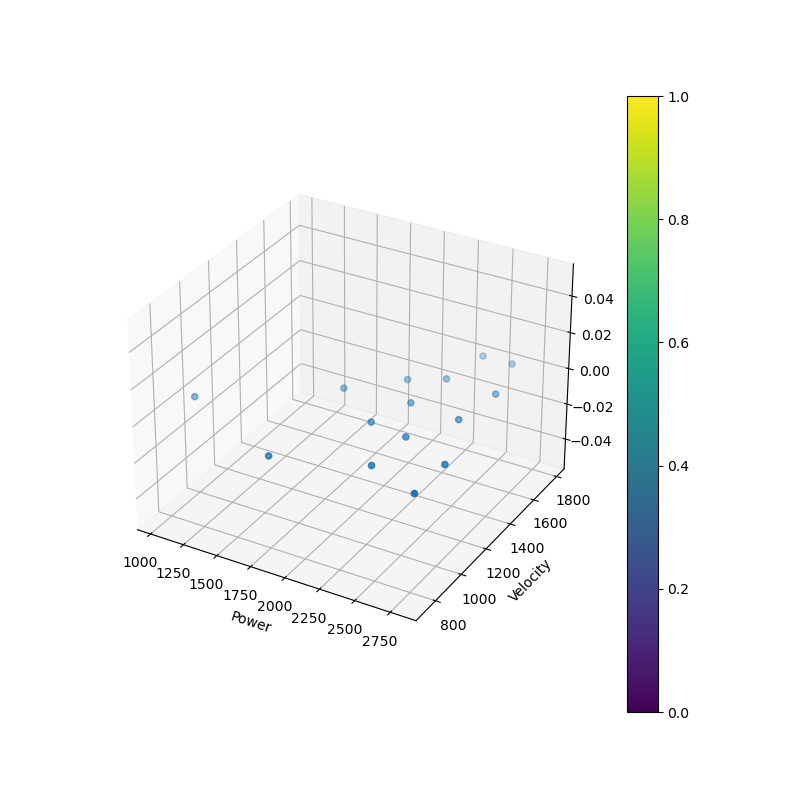

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel("Power")
ax.set_ylabel("Velocity")
# ax.set_zlabel("Spot size")
# ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,3])
img = ax.scatter(X[:,0], X[:,1])
fig.colorbar(img)
plt.show()

In [7]:
# from mpl_toolkits.mplot3d import axes3d

In [8]:
# fig = plt.figure()
# ax = axes3d

# plot = ax.scatter(X[:,0], X[:,1], X[:,2])

In [9]:
# Store for un_transform later
xrange_list, xmin_list = store_param(X, 2)

In [10]:
bounds = torch.tensor([[900, 2700], [600, 1800]], **tkwargs)

In [11]:
X = transform(X, 2, bounds)

# You can verify the Normalization is correct by undoing the above step and comparing to original data
# X = un_transform(X, xrange_list, xmin_list, 4) 

In [12]:
X

tensor([[0.5094, 0.1083],
        [0.4978, 0.5833],
        [0.0717, 0.3000],
        [0.9356, 0.9917],
        [0.8439, 0.2167],
        [0.9844, 0.7917],
        [0.9550, 0.5917],
        [0.8528, 0.4167],
        [0.7544, 0.6083],
        [0.7817, 0.8000],
        [0.6994, 0.4417],
        [1.0556, 0.3333],
        [0.6639, 0.7333],
        [0.8172, 0.9917],
        [1.0556, 0.1417]], dtype=torch.float64)

In [13]:
list_of_models = initialize_models(X, width, pow_cap, wth) # You can put in arbitrary amount of output parameters

In [14]:
punchout_radius = 0.1
bounds = torch.tensor([[0, 0], [1, 1]], **tkwargs) # Because we normalized
# bounds = torch.tensor([[-0.082,-0.122], [1.074,1.01]], **tkwargs)
lb, ub = bounds


In [15]:
constraints = [("gt", 2.5), ("gt", 0.65), ("gt", 6)]
# normalization
# mean = X.mean(dim=-2, keepdim=True)
# std = X.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
# X = (X - mean) / std

In [16]:
# How many new points do we want
num_pred = 5
Ytemp = [width, pow_cap, wth] #Store temps for test point generation

In [17]:
X

tensor([[0.5094, 0.1083],
        [0.4978, 0.5833],
        [0.0717, 0.3000],
        [0.9356, 0.9917],
        [0.8439, 0.2167],
        [0.9844, 0.7917],
        [0.9550, 0.5917],
        [0.8528, 0.4167],
        [0.7544, 0.6083],
        [0.7817, 0.8000],
        [0.6994, 0.4417],
        [1.0556, 0.3333],
        [0.6639, 0.7333],
        [0.8172, 0.9917],
        [1.0556, 0.1417]], dtype=torch.float64)

In [18]:
# un_transform(torch.tensor([[1.074,1.01]]), xrange_list, xmin_list, 2)

Max power: 2700W
Min power: 900W
Max speed: 1800 mm/min
Min speed: 600 mm/min

In [19]:
xmin_list = torch.tensor([900, 600])


In [20]:
xrange_list = torch.tensor([1800, 1200])

In [21]:
model, X = generate_test_points(X, num_pred, Ytemp, constraints, punchout_radius, bounds)
print(X)
X = un_transform(X, xrange_list, xmin_list, 2)

fixed features
fixed features
fixed features
fixed features
fixed features
tensor([[0.5094, 0.1083],
        [0.4978, 0.5833],
        [0.0717, 0.3000],
        [0.9356, 0.9917],
        [0.8439, 0.2167],
        [0.9844, 0.7917],
        [0.9550, 0.5917],
        [0.8528, 0.4167],
        [0.7544, 0.6083],
        [0.7817, 0.8000],
        [0.6994, 0.4417],
        [1.0556, 0.3333],
        [0.6639, 0.7333],
        [0.8172, 0.9917],
        [1.0556, 0.1417],
        [1.0000, 0.4547],
        [0.3922, 1.0000],
        [0.3881, 0.8032],
        [0.2201, 0.9124],
        [0.0446, 1.0000]], dtype=torch.float64)


In [22]:
new_N_points = X[-num_pred:]
for i in range(new_N_points.shape[0], 0, -1):
    new_power = round(X[-i][0].item(), 2)
    new_velocity = round(X[-i][1].item(), 2)
    # new_spotsize = round(X[-i][2].item(), 2)
    # new_feedrate = round(X[-i][3].item(), 2)
    print(f"New X_{new_N_points.shape[0]+1-i}: Power: {new_power}W, Velocity: {new_velocity}mm/min")

New X_1: Power: 2700.0W, Velocity: 1145.63mm/min
New X_2: Power: 1605.99W, Velocity: 1800.0mm/min
New X_3: Power: 1598.58W, Velocity: 1563.84mm/min
New X_4: Power: 1296.16W, Velocity: 1694.9mm/min
New X_5: Power: 980.36W, Velocity: 1800.0mm/min


In [23]:
X

tensor([[1817.0000,  730.0000],
        [1796.0000, 1300.0000],
        [1029.0000,  960.0000],
        [2584.0000, 1790.0000],
        [2419.0000,  860.0000],
        [2672.0000, 1550.0000],
        [2619.0000, 1310.0000],
        [2435.0000, 1100.0000],
        [2258.0000, 1330.0000],
        [2307.0000, 1560.0000],
        [2159.0000, 1130.0000],
        [2800.0000, 1000.0000],
        [2095.0000, 1480.0000],
        [2371.0000, 1790.0000],
        [2800.0000,  770.0000],
        [2700.0000, 1145.6327],
        [1605.9856, 1800.0000],
        [1598.5848, 1563.8363],
        [1296.1647, 1694.8958],
        [ 980.3634, 1800.0000]], dtype=torch.float64)

In [24]:
feasible_inds_width = (
    identify_samples_which_satisfy_constraints(width, constraints[0])
    .prod(dim=-1)
    .to(torch.bool)
)

In [25]:
feasible_inds_pow_cap = (
    identify_samples_which_satisfy_constraints(pow_cap, constraints[1])
    .prod(dim=-1)
    .to(torch.bool)
)

In [26]:
feasible_inds_wth = (
    identify_samples_which_satisfy_constraints(wth, constraints[2])
    .prod(dim=-1)
    .to(torch.bool)
)

In [27]:
Xplt = X[:10,:]

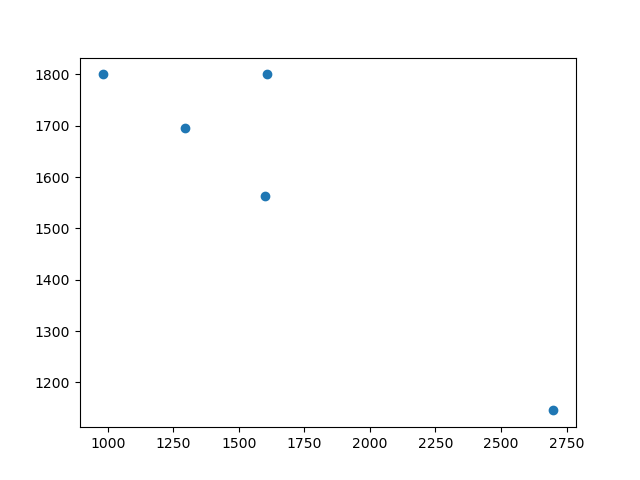

In [28]:
plt.scatter(X.float().numpy()[15:, 0], X.float().numpy()[15:, 1])
# plt.plot(Xplt[feasible_inds_width, 0].cpu(), Xplt[feasible_inds_width, 1].cpu(), "og")
# plt.plot(Xplt[feasible_inds_wth, 0].cpu(), Xplt[feasible_inds_wth, 1].cpu(), "og")
# plt.scatter(X.float().numpy()[5:, 0], X.float().numpy()[5:, 1], color='k')
plt.show()

In [29]:
list_of_models[0]

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Interval(1.000E-09, 1.000E-06)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

In [30]:
N1, N2 = 150, 150
Xplt, Yplt = torch.meshgrid(
    torch.linspace(0, 1, N1, **tkwargs), torch.linspace(0, 1, N2, **tkwargs),
    indexing='xy',
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)
Xplt, Yplt = torch.meshgrid(
    torch.linspace(900, 2700, N1, **tkwargs), torch.linspace(600, 1800, N2, **tkwargs),
    indexing='xy',
)

In [31]:
xplt = xplt.double()

In [32]:
# Xplt = un_transform(Xplt.clone(), xrange_list, xmin_list, 2).double()

In [33]:
Xtemp = X[:15]

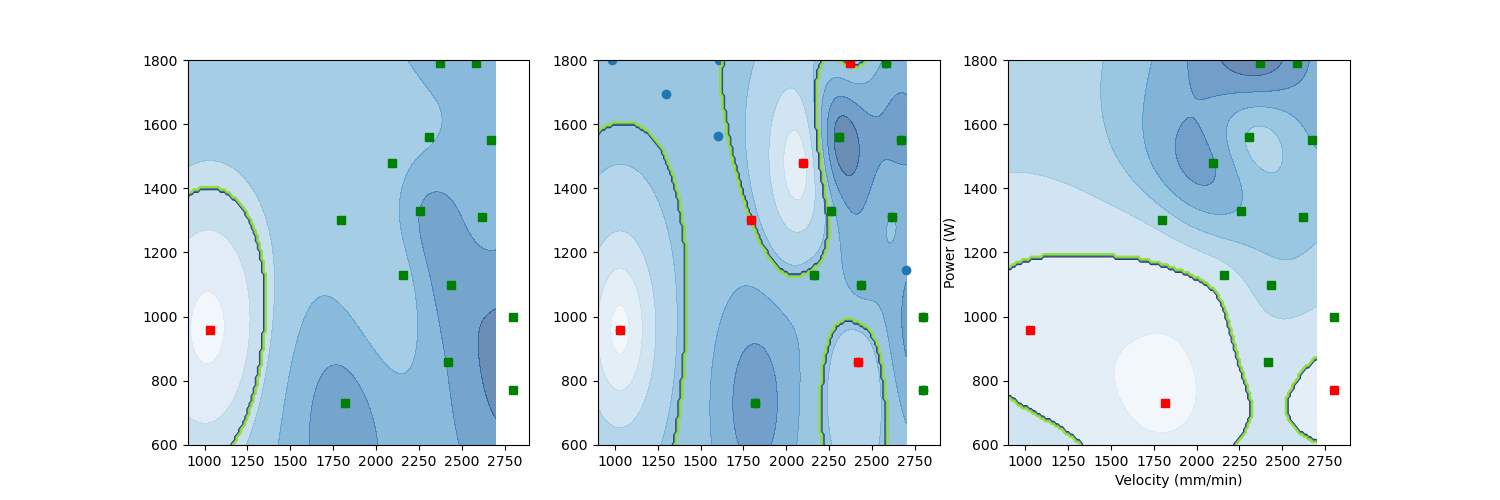

In [38]:
# plt.subplots(3, figsize=(8, 8))
predicted_width = model[0](xplt).loc.detach().reshape(N1,N2)
predicted_pow_cap = model[1](xplt).loc.detach().reshape(N1,N2)
predicted_wth = model[2](xplt).loc.detach().reshape(N1,N2)

est_width = predicted_width > 2.5
est_pow_cap = predicted_pow_cap > 0.65
est_wth = predicted_wth > 6

reference = (est_width & est_pow_cap & est_wth)
plt.figure(1)
fig, ax = plt.subplots(1,3, figsize=(15, 5))
# Xplt = un_transform(Xplt, xrange_list, xmin_list, 2)
ax[0].contourf(Xplt.cpu(), Yplt.cpu(), predicted_width.cpu(),cmap="Blues", alpha=0.6)
ax[0].contour(Xplt.cpu(), Yplt.cpu(), est_width.cpu())
ax[0].plot(Xtemp[feasible_inds_width, 0].cpu(), Xtemp[feasible_inds_width, 1].cpu(), "sg", label="In Boundary")
ax[0].plot(Xtemp[~feasible_inds_width, 0].cpu(), Xtemp[~feasible_inds_width, 1].cpu(), "sr", label="Out of Boundary")
ax[1].contourf(Xplt.cpu(), Yplt.cpu(), predicted_pow_cap.cpu(),cmap="Blues", alpha=0.6)
ax[1].contour(Xplt.cpu(), Yplt.cpu(), est_pow_cap.cpu())
ax[1].scatter(X.float().numpy()[:, 0], X.float().numpy()[:, 1])
ax[1].plot(Xtemp[feasible_inds_pow_cap, 0].cpu(), Xtemp[feasible_inds_pow_cap, 1].cpu(), "sg", label="In Boundary")
ax[1].plot(Xtemp[~feasible_inds_pow_cap, 0].cpu(), Xtemp[~feasible_inds_pow_cap, 1].cpu(), "sr", label="Out of Boundary")
ax[2].contourf(Xplt.cpu(), Yplt.cpu(), predicted_wth.cpu(),cmap="Blues", alpha=0.6)
ax[2].contour(Xplt.cpu(), Yplt.cpu(), est_wth.cpu())
ax[2].plot(Xtemp[feasible_inds_wth, 0].cpu(), Xtemp[feasible_inds_wth, 1].cpu(), "sg", label="In Boundary")
ax[2].plot(Xtemp[~feasible_inds_wth, 0].cpu(), Xtemp[~feasible_inds_wth, 1].cpu(), "sr", label="Out of Boundary")
# ax[0].contourf(Xplt.cpu(), Yplt.cpu(), reference.cpu())

# plt.contourf(Xplt.cpu(), Yplt.cpu(), reference.cpu(), cmap="Blues", alpha=0.6)
plt.xlabel('Velocity (mm/min)')
plt.ylabel('Power (W)')
plt.show()

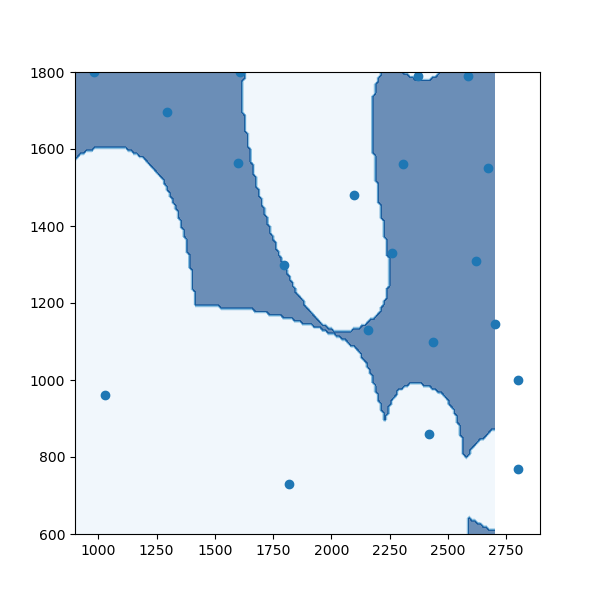

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(Xplt.cpu(), Yplt.cpu(), reference.cpu(),cmap="Blues", alpha=0.6)
ax.scatter(X.float().numpy()[:, 0], X.float().numpy()[:, 1])
plt.show()

In [36]:
# fig = plt.figure(figsize=(8, 8))
# ax = plt.axes(projection='3d')
# ax.set_xlabel("Power")
# ax.set_ylabel("Velocity")
# ax.set_zlabel("Spot size")
# # ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,3])
# img = ax.scatter(X[:-num_pred,0], X[:-num_pred,1], X[:-num_pred,2], c=X[:-num_pred,3])
# img = ax.scatter(X[-num_pred:,0], X[-num_pred:,1], X[-num_pred:,2], c=X[-num_pred:,3], marker = "x")
# fig.colorbar(img)
# plt.show()